## This notebook utilizes the tool to make a refine-sample-coarsen model topography 

In [1]:
import GMesh
import imp  
import inspect
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## GridMesh Class

In [2]:
#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
imp.reload(GMesh) 
help(GMesh)

Help on module GMesh:

NAME
    GMesh

CLASSES
    builtins.object
        GMesh
    
    class GMesh(builtins.object)
     |  Describes 2D meshes for ESMs.
     |  
     |  Meshes have shape=(nj,ni) cells with (nj+1,ni+1) vertices with coordinates (lon,lat).
     |  
     |  When constructing, either provide 1d or 2d coordinates (lon,lat), or assume a
     |  uniform spherical grid with 'shape' cells covering the whole sphere with
     |  longitudes starting at lon0.
     |  
     |  Attributes:
     |  
     |  shape - (nj,ni)
     |  ni    - number of cells in i-direction (last)
     |  nj    - number of cells in j-direction (first)
     |  lon   - longitude of mesh (cell corners), shape (nj+1,ni=1)
     |  lat   - latitude of mesh (cell corners), shape (nj+1,ni=1)
     |  area  - area of cells, shape (nj,ni)
     |  
     |  Methods defined here:
     |  
     |  __getitem__(self, key)
     |  
     |  __init__(self, shape=None, lon=None, lat=None, area=None, lon0=-180.0, from_cell

## Read GEBCO dataset for topography

In [3]:
# # Open and read the topographic dataset
# Open a topography dataset, check that the topography is on a uniform grid.
# URL of topographic data, names of longitude, latitude and elevation variables
url,vx,vy,ve = '/net2/nnz/thin-wall-topography/python/workdir/GEBCO_2014_2D.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO1/.z_bedrock/dods','lon','lat','z_bedrock'
topo_data = netCDF4.Dataset(url)
# Read coordinates of topography
topo_lons = np.array( topo_data.variables[vx][:] )
topo_lats = np.array( topo_data.variables[vy][:] )
topo_elvs = np.array( topo_data.variables[ve][:,:] )
#Translate topo data to start at target_mesh.lon[0]
topo_lons = np.roll(topo_lons,14400,axis=0) #Roll GEBCO longitude to right. 14400 was a lucky guess that checked out!
topo_lons = np.where(topo_lons>60 , topo_lons-360, topo_lons) #Rename (0,60) as (-300,-180) 
topo_elvs = np.roll(topo_elvs,14400,axis=1) #Roll GEBCO depth to the right by the same amount.
topo_wet=np.zeros(topo_elvs.shape)
topo_wet=np.where(topo_elvs<0.,1.0,0.0)
print(' topography grid array shapes: ' , topo_lons.shape,topo_lats.shape,topo_elvs.shape)
print(' topography longitude range:',topo_lons.min(),topo_lons.max())
print(' topography latitude range:',topo_lats.min(),topo_lats.max())
print(' Is mesh uniform?', GMesh.is_mesh_uniform( topo_lons, topo_lats ) )
#plt.figure(figsize=(10,10))
#plt.pcolormesh(topo_lons[::100], topo_lats[::100],topo_elvs[::100,::100]);plt.colorbar();

 topography grid array shapes:  (43200,) (21600,) (21600, 43200)
 topography longitude range: -299.99583333333334 59.99583333333334
 topography latitude range: -89.99583333333332 89.99583333333334
 Is mesh uniform? True


## Read the target grid

Terget grid is the underlying finite element 2D supergrid to be used in the Ocean model. Here we choose a 1/4 degree Mercator grid  generated by using the [grid_generation tool](https://github.com/nikizadehgfdl/grid_generation). 

In [4]:
#Read in Mercator grid for 1/4 degree model
targ_grid =  netCDF4.Dataset('/work3/nnz/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing/ocean_hgrid.ncMerc.nc')
targ_lon = np.array(targ_grid.variables['x'])
targ_lat = np.array(targ_grid.variables['y'])
#x and y have shape (nyp,nxp). Topog does not need the last col for global grids (period in x). 
targ_lon = targ_lon[:,:-1]
targ_lat = targ_lat[:,:-1]
print(" Target mesh shape: ",targ_lon.shape)

 Target mesh shape:  (2801, 5760)


## Divide the Target grid into blocks
 The target grid is uaually too big to be handled in one go. Hence, we break the target to pieces and handle them one at a time. 

In [5]:
import create_topog_refinedSampling as topotool
xb=4 # of partitions in the logical x-direction 
yb=1
lons=topotool.break_array_to_blocks(targ_lon,xb,yb)
lats=topotool.break_array_to_blocks(targ_lat,xb,yb)

## Refine, Sample (by averaging), Coarsen procedure

For demonstration purposes do only the 3rd block which contains the Black Sea region. But this has to be done for all the blocks and the results merged (using topotool.undo_break_array_to_blocks() subroutine).

In [ ]:
part=3 #for demonstration, contains Black Sea
lon = lons[part]
lat = lats[part]
h,hstd,hmin,hmax = topotool.do_block(part,lon,lat,topo_lons,topo_lats,topo_elvs)

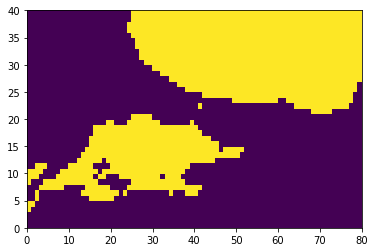

In [20]:
wet=np.zeros(h.shape)
wet=np.where(h<0, 1.0,0.0)
jtrg0,itrg0=topotool.get_indices2D(lon, lat ,29.03, 41.04)
di0,dj0=40,20
itrgm,itrgp = itrg0-di0, itrg0+di0
jtrgm,jtrgp = jtrg0-dj0, jtrg0+dj0
plt.pcolormesh(wet[jtrgm:jtrgp,itrgm:itrgp])

## Refine, Sample (by minimum), Coarsen 

As you see the Bosphorus Chanell is missing and the Black Sea is not connected even though it was present in the source topography. This is because when we refined and zoomed in we picked up the wet point but the neighboring points were land and when we average over four neighors the chanell goes away.

The easiest way out is not to average over the four points but to pick up the minimum height (hmin) as the height.

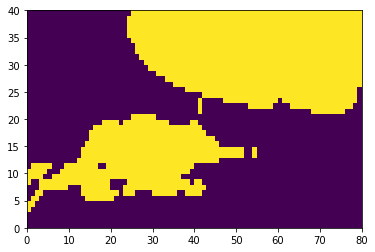

In [21]:
wetmin=np.zeros(hmin.shape)
wetmin=np.where(hmin<0, 1.0,0.0)
plt.pcolormesh(wetmin[jtrgm:jtrgp,itrgm:itrgp])

## So, The method of minimums does not work for 1/8 degree grid as it did for 1/4 degree! Why?


Were we just lucky for the 1/4 degree grid?

Note that all source points are hit here as were in 1/4 degree.

Also note that there is clearly a Bosphorus path in the source data as shown below.

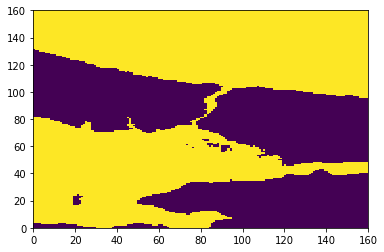

In [26]:
#Zoom in on Black Sea channel
jsrc0,isrc0=topotool.get_indices1D(topo_lons, topo_lats ,29.03, 41.04)
#print(topo_elvs[j0,i0-1]) #-32
di0,dj0=80,80
isrcm,isrcp = isrc0-di0, isrc0+di0
jsrcm,jsrcp = jsrc0-dj0, jsrc0+dj0
plt.pcolormesh(topo_wet[jsrcm:jsrcp,isrcm:isrcp])

## Opening Selective Channels

Another way out, which unlike the hmin approach is subjective, is to widen the channel in the source topography so that the result of averaging are wet points. This is a very subjective approach that would need identifying all the chanells over the globe and for each one to choose how wide it shoud get to result a channel in the final (ice9ed) topography. 

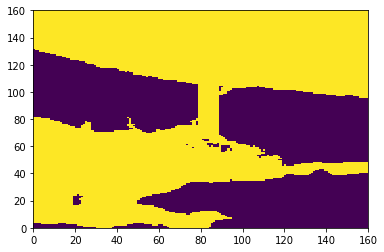

In [33]:
topo_elvs2 = 1.0*topo_elvs + 0.0
#Fix the topography to open some channels
open_channels = True
if(open_channels):
    j2,i2=topotool.get_indices1D(topo_lons, topo_lats ,29.1, 41.3)
    topo_elvs2[jsrc0-10:j2,isrc0-1:i2]=topo_elvs[jsrc0,isrc0-1]
#    j1,i1=get_indices1D(topo_lons, topo_lats ,26., 40.) #Dardanells
#    topo_elvs2[j1+1,i1]=topo_elvs[j1,i1]    
topo_wet2=np.zeros(topo_elvs2.shape)
topo_wet2=np.where(topo_elvs2<0.,1.0,0.0)
plt.pcolormesh(topo_wet2[jsrcm:jsrcp,isrcm:isrcp])    

  Doing block number  3
  Target sub mesh shape:  (2801, 1440)
  Slices j,i: slice(2773, 18484, 2) slice(32400, 43193, 2)
  Topo shape: (7856, 5397)
  topography longitude range: -29.995833333333334 59.9375
  topography latitude  range: -66.8875 64.02916666666667
  Target     longitude range: -30.0 59.9375
  Target     latitude  range: -66.88409658467617 64.03160594077568
  Refining the target to hit all source points ...
<GMesh nj:2800 ni:1439 shape:(2800,1439)> Hit 4033440 out of 42398832 cells (61.4807 Mb)
<GMesh nj:5600 ni:2878 shape:(5600,2878)> Hit 15778981 out of 42398832 cells (245.9229 Mb)
<GMesh nj:11200 ni:5756 shape:(11200,5756)> Hit 42398832 out of 42398832 cells (983.6914 Mb)
  non-hit ratio:  0  /  42398832
  Sampling the source points on target mesh ...
  Sampling finished...
  Coarsening back to the original taget grid ...



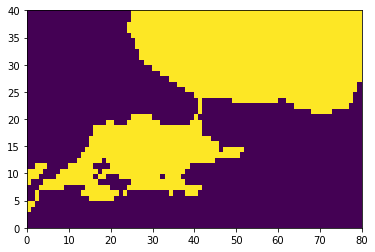

In [34]:
#result of opening a wide channel
h2,hstd2,hmin2,hmax2 = topotool.do_block(part,lon,lat,topo_lons,topo_lats,topo_elvs2)
wet2=np.zeros(h2.shape)
wet2=np.where(h2<0, 1.0,0.0)
plt.pcolormesh(wet2[jtrgm:jtrgp,itrgm:itrgp])

## Water Bridges

Another objective although arbitrary way is to make water bridges in the SW-NE direction. This could be done as a part of ice9 procedure.

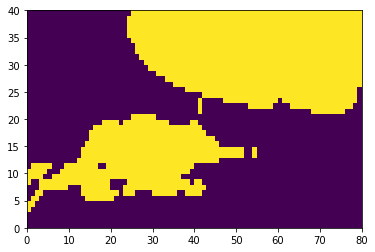

In [48]:
plt.pcolormesh(wetmin[jtrgm:jtrgp,itrgm:itrgp])

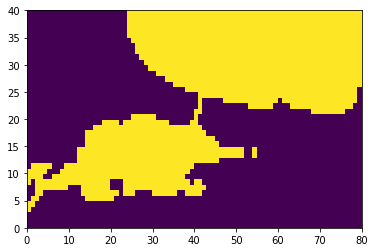

In [50]:
hb = 1.0*hmin + 0.0
for j in range(1,hb.shape[0]-1):
    for i in range(1,hb.shape[1]-1):
        if(hmin[j,i]>0 and hmin[j-1,i]<0 and hmin[j+1,i+1]<0):
            hb[j,i] = 0.5*(hmin[j-1,i]+hmin[j+1,i+1])
            hb[j+1,i] = hb[j,i]
wetb=np.zeros(hb.shape)
wetb=np.where(hb<0, 1.0,0.0)
plt.pcolormesh(wetb[jtrgm:jtrgp,itrgm:itrgp])

### The above is on the supergrid. The simple-sampled mask on the grid is again disconnected:

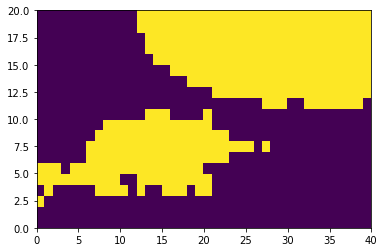

In [51]:
hbs = hb[:-1:2,:-1:2]
wetbs=np.zeros(hbs.shape)
wetbs=np.where(hbs<0, 1.0,0.0)
plt.pcolormesh(wetbs[jtrgm//2:jtrgp//2,itrgm//2:itrgp//2])

### We are losing information by simple-sampling from supergrid to grid. We can do better.

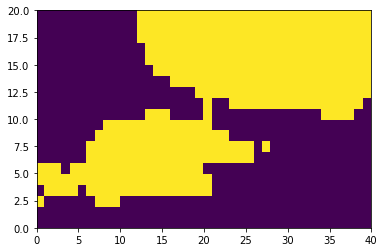

In [52]:
hbs2 = np.minimum(hb[:-1:2,:-1:2],hb[1::2,1::2])

wetbs2=np.zeros(hbs2.shape)
wetbs2=np.where(hbs2<0, 1.0,0.0)
plt.pcolormesh(wetbs2[jtrgm//2:jtrgp//2,itrgm//2:itrgp//2])

### And we do not even need to build bridges

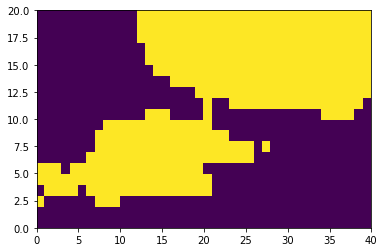

In [53]:
hmin2 = np.minimum(hmin[:-1:2,:-1:2],hmin[1::2,1::2])

wetmin2=np.zeros(hmin2.shape)
wetmin2=np.where(hmin2<0, 1.0,0.0)
plt.pcolormesh(wetmin2[jtrgm//2:jtrgp//2,itrgm//2:itrgp//2])

## Inspect the generated topography

In [11]:
#targ_topo =  netCDF4.Dataset('/work3/nnz/MOM6-examples_myfork/ice_ocean_SIS2/OM4_025/preprocessing.new/topog_editted.nc')
#j0,i0 = 680,1320
#targ_topo =  netCDF4.Dataset('/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing/topog_editted.nc')
#j0,i0 = 1446,2630
#targ_topo =  netCDF4.Dataset('/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_025/preprocessing.new/topog_MERC.nc')
targ_topo =  netCDF4.Dataset('/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing/topog_MERC.nc')

targ_x = np.array(targ_topo.variables['x'])
targ_y = np.array(targ_topo.variables['y'])
targ_h = np.array(targ_topo.variables['h_min'])
print(targ_h.shape)
targ_wet=np.zeros(targ_h.shape)
targ_wet=np.where(targ_h<0.,1.0,0.0)

(2801, 5760)


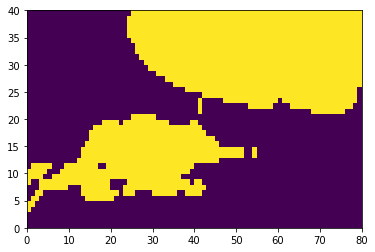

In [12]:
#Zoom in on Black Sea channel
#import create_topog_refinedSampling as topotool
j0,i0=topotool.get_indices2D(targ_x, targ_y ,29.03, 41.04)
di0,dj0=40,20
im,ip = i0-di0, i0+di0
jm,jp = j0-dj0, j0+dj0
plt.pcolormesh(targ_wet[jm:jp,im:ip])